In [3]:
import sys
import importlib
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
base_path = "../src/"
sys.path.append(base_path)
import models
import train
from losses import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
#datafilename='/mnt/ceph/users/sgenel/CAMELS/gal_sbi/DATA/data_L25LH_TNG.hdf5'
datafilename='/mnt/ceph/users/sgenel/CAMELS/gal_sbi/DATA/data_L50_TNG_v3.hdf5'
with h5py.File(datafilename, 'r') as f:
    print("Datasets available:")
    for key in f.keys():
        print(key)

with h5py.File(datafilename, 'r') as f:
    #Parameters = f['Parameters'][0, :1024].T.reshape(-1, 1)
    Parameters = f['Parameters'][:, :1024].T
logflag = np.array([False, False, True, True, True, True, False, False, False, True, True, False, False, True, False, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, True, False, False, False, True])
logflag = logflag[:Parameters.shape[1]]
origParameters = Parameters
if not np.all(Parameters[:, logflag] > 0):
    raise ValueError("Some values to be logged are non-positive.")
PartiallyLoggedParameters = Parameters.copy()
PartiallyLoggedParameters[:, logflag] = np.log(PartiallyLoggedParameters[:, logflag])
means = PartiallyLoggedParameters.mean(axis=0)
stds = PartiallyLoggedParameters.std(axis=0)
Parameters = (PartiallyLoggedParameters - means) / stds

with h5py.File(datafilename, 'r') as f:
    Ms_Mh_s90 = f['Ms_Mh_s90'][:].T
    Ms_Mh_s61 = f['Ms_Mh_s61'][:].T
    MBH_Mh_s90 = f['MBH_Mh_s90'][:].T
    MBH_Mh_s61 = f['MBH_Mh_s61'][:].T
    Mg_Mh_s90 = f['Mg_Mh_s90'][:].T
    Mg_Mh_s61 = f['Mg_Mh_s61'][:].T
    Rs_Ms_s90 = f['Rs_Ms_s90'][:].T
    Rs_Ms_s61 = f['Rs_Ms_s61'][:].T
    SFR_Ms_s90 = f['SFR_Ms_s90'][:].T
    SFR_Ms_s61 = f['SFR_Ms_s61'][:].T
    Zs_Ms_s90 = f['Zs_Ms_s90'][:].T
    Zs_Ms_s61 = f['Zs_Ms_s61'][:].T
    SFRH_100Myr = f['SFRH_100Myr'][:].T

Datasets available:
MBH_Mh_s61
MBH_Mh_s90
Mg_Mh_s61
Mg_Mh_s90
Ms_Mh_s61
Ms_Mh_s90
Parameters
Rs_Ms_s61
Rs_Ms_s90
SFRH
SFRH_100Myr
SFRH_z
SFR_Ms_s61
SFR_Ms_s90
Zs_Ms_s61
Zs_Ms_s90
logMh_s61
logMh_s90
logMs_s61
logMs_s90


In [36]:
# choose which observables to include
#x = torch.from_numpy(Ms_Mh_s90).float()
#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61)), dim=1).float()
#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61)), dim=1).float()
x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61), torch.from_numpy(Rs_Ms_s90), torch.from_numpy(Rs_Ms_s61), torch.from_numpy(SFR_Ms_s90), torch.from_numpy(SFR_Ms_s61), torch.from_numpy(Zs_Ms_s90), torch.from_numpy(Zs_Ms_s61), torch.from_numpy(SFRH_100Myr)), dim=1).float()

print("Total NaNs:", torch.isnan(x).sum().item())
print("Total Infs:", torch.isinf(x).sum().item())
x[torch.isnan(x)] = 11
x[torch.isinf(x)] = 11
print("Total NaNs:", torch.isnan(x).sum().item())
print("Total Infs:", torch.isinf(x).sum().item())
y = torch.from_numpy(Parameters).float()
print(x.shape)
print(y.shape)

Total NaNs: 0
Total Infs: 0
Total NaNs: 0
Total Infs: 0
torch.Size([1024, 253])
torch.Size([1024, 35])


In [37]:
# Hyperparameters
input_dim    = x.shape[1]
output_dim   = y.shape[1]
hidden_dims  = [128, 64]
#hidden_dims  = [128, 64, 64]
#hidden_dims  = [64, 64]
lr           = 1e-4
wd           = 1e-5
dropout_rate = 0.2
epochs       = 2000
val_fraction = 0.1
batch_size   = 64
separate_models = True

In [38]:
n_val = int(len(x) * val_fraction)
perm = torch.randperm(len(x))
idx_train = perm[:-n_val]
idx_val = perm[-n_val:]

x_train, y_train = x[idx_train], y[idx_train]
x_val, y_val = x[idx_val], y[idx_val]

In [46]:
importlib.reload(train)
importlib.reload(models)

<module 'models' from '/mnt/ceph/users/sgenel/CAMELS/gal_sbi/code/camelsPE/jupyter_notebook/../src/models.py'>

In [47]:
# model, optimizer, loss function
criterion = MSELoss()
if separate_models and output_dim > 1:
    models_list = [models.SimpleMLP(input_dim, hidden_dims, 1, dropout_rate).to(device) for _ in range(output_dim)]
    optimizers = [optim.Adam(m.parameters(), lr=lr, weight_decay=wd) for m in models_list]
else:
    model = models.SimpleMLP(input_dim, hidden_dims, output_dim, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [49]:
train_losses_list, val_losses_list = [], []
if separate_models and output_dim > 1:
    for i, (model_i, opt_i) in enumerate(zip(models_list, optimizers)):
        print(f"model #{i:d}")
        tl, vl = train.fit(
            model_i,
            DataLoader(TensorDataset(x_train, y_train[:, i:i+1]), batch_size=batch_size, shuffle=True),
            DataLoader(TensorDataset(x_val, y_val[:, i:i+1]), batch_size=batch_size, shuffle=False),
            opt_i, criterion, device, epochs)
        train_losses_list.append(tl)
        val_losses_list.append(vl)
    train_losses = np.mean(np.stack(train_losses_list), axis=0)
    val_losses = np.mean(np.stack(val_losses_list), axis=0)
else:
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    train_losses, val_losses = train.fit(model, train_loader, val_loader, optimizer, criterion, device, epochs)

model #0


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.0826
[Iter 1000] validation loss: 0.0785
[Iter 1500] validation loss: 0.0823
[Iter 2000] validation loss: 0.0833
model #1


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5026
[Iter 1000] validation loss: 0.5023
[Iter 1500] validation loss: 0.5018
[Iter 2000] validation loss: 0.5301
model #2


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5440
[Iter 1000] validation loss: 0.5688
[Iter 1500] validation loss: 0.5480
[Iter 2000] validation loss: 0.5787
model #3


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.2006
[Iter 1000] validation loss: 1.2450
[Iter 1500] validation loss: 1.2238
[Iter 2000] validation loss: 1.2409
model #4


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3713
[Iter 1000] validation loss: 0.3238
[Iter 1500] validation loss: 0.3367
[Iter 2000] validation loss: 0.3212
model #5


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.1001
[Iter 1000] validation loss: 1.1092
[Iter 1500] validation loss: 1.1705
[Iter 2000] validation loss: 1.1821
model #6


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3915
[Iter 1000] validation loss: 0.3044
[Iter 1500] validation loss: 0.3000
[Iter 2000] validation loss: 0.2774
model #7


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.2771
[Iter 1000] validation loss: 0.2051
[Iter 1500] validation loss: 0.1703
[Iter 2000] validation loss: 0.1746
model #8


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5842
[Iter 1000] validation loss: 0.4964
[Iter 1500] validation loss: 0.4893
[Iter 2000] validation loss: 0.5496
model #9


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.8430
[Iter 1000] validation loss: 0.9442
[Iter 1500] validation loss: 0.9877
[Iter 2000] validation loss: 1.0507
model #10


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.8478
[Iter 1000] validation loss: 0.9081
[Iter 1500] validation loss: 0.9119
[Iter 2000] validation loss: 0.9169
model #11


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.1076
[Iter 1000] validation loss: 0.0982
[Iter 1500] validation loss: 0.0902
[Iter 2000] validation loss: 0.0923
model #12


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.8726
[Iter 1000] validation loss: 0.8406
[Iter 1500] validation loss: 0.8328
[Iter 2000] validation loss: 0.8690
model #13


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.0518
[Iter 1000] validation loss: 1.1045
[Iter 1500] validation loss: 1.1081
[Iter 2000] validation loss: 1.1609
model #14


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.8639
[Iter 1000] validation loss: 0.8512
[Iter 1500] validation loss: 0.8963
[Iter 2000] validation loss: 0.8029
model #15


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.7780
[Iter 1000] validation loss: 0.6105
[Iter 1500] validation loss: 0.5721
[Iter 2000] validation loss: 0.6004
model #16


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.6671
[Iter 1000] validation loss: 0.5925
[Iter 1500] validation loss: 0.5661
[Iter 2000] validation loss: 0.6410
model #17


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9746
[Iter 1000] validation loss: 0.9041
[Iter 1500] validation loss: 0.9006
[Iter 2000] validation loss: 0.8439
model #18


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.0715
[Iter 1000] validation loss: 1.0593
[Iter 1500] validation loss: 1.0988
[Iter 2000] validation loss: 1.0601
model #19


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9700
[Iter 1000] validation loss: 0.9910
[Iter 1500] validation loss: 1.0402
[Iter 2000] validation loss: 1.0843
model #20


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.7082
[Iter 1000] validation loss: 0.5999
[Iter 1500] validation loss: 0.5703
[Iter 2000] validation loss: 0.5762
model #21


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.0360
[Iter 1000] validation loss: 1.1020
[Iter 1500] validation loss: 1.1192
[Iter 2000] validation loss: 1.1452
model #22


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.6428
[Iter 1000] validation loss: 0.6415
[Iter 1500] validation loss: 0.6993
[Iter 2000] validation loss: 0.7047
model #23


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.0796
[Iter 1000] validation loss: 1.0634
[Iter 1500] validation loss: 1.0331
[Iter 2000] validation loss: 1.0545
model #24


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.0679
[Iter 1000] validation loss: 1.0691
[Iter 1500] validation loss: 1.0778
[Iter 2000] validation loss: 1.0292
model #25


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.6451
[Iter 1000] validation loss: 0.5837
[Iter 1500] validation loss: 0.6023
[Iter 2000] validation loss: 0.5859
model #26


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.8005
[Iter 1000] validation loss: 0.7623
[Iter 1500] validation loss: 0.8182
[Iter 2000] validation loss: 0.8551
model #27


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.6777
[Iter 1000] validation loss: 0.7038
[Iter 1500] validation loss: 0.7303
[Iter 2000] validation loss: 0.7343
model #28


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9240
[Iter 1000] validation loss: 0.8269
[Iter 1500] validation loss: 0.8279
[Iter 2000] validation loss: 0.8790
model #29


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.1333
[Iter 1000] validation loss: 1.1746
[Iter 1500] validation loss: 1.2245
[Iter 2000] validation loss: 1.2739
model #30


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.0403
[Iter 1000] validation loss: 1.0267
[Iter 1500] validation loss: 1.0015
[Iter 2000] validation loss: 1.0245
model #31


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 1.0422
[Iter 1000] validation loss: 1.0630
[Iter 1500] validation loss: 1.0685
[Iter 2000] validation loss: 1.1291
model #32


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9729
[Iter 1000] validation loss: 0.9844
[Iter 1500] validation loss: 0.9927
[Iter 2000] validation loss: 1.0464
model #33


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9320
[Iter 1000] validation loss: 0.9952
[Iter 1500] validation loss: 1.0422
[Iter 2000] validation loss: 1.0822
model #34


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5348
[Iter 1000] validation loss: 0.4756
[Iter 1500] validation loss: 0.4337
[Iter 2000] validation loss: 0.4708


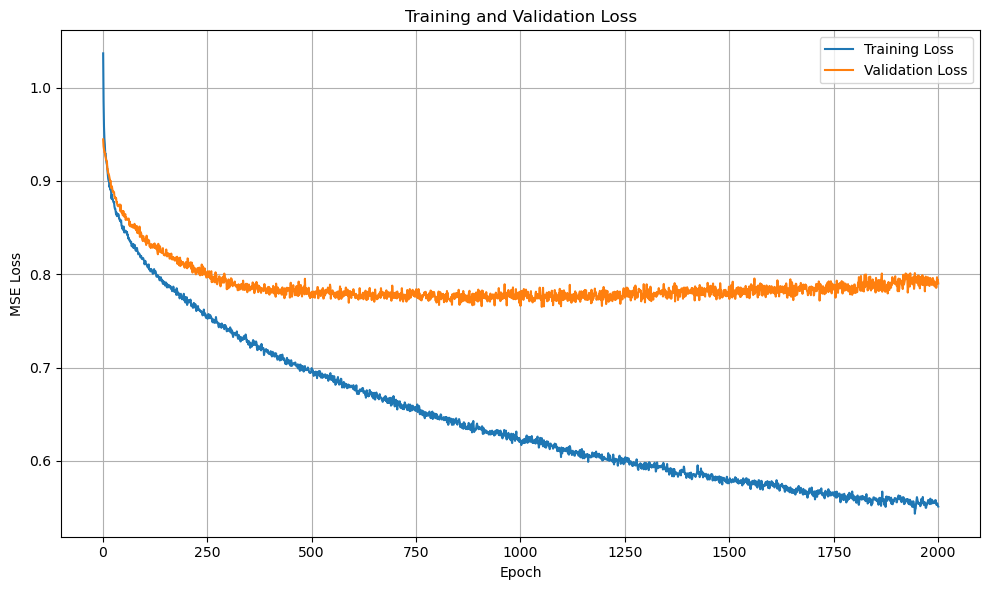

In [50]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../../../plots/training_plot.png")
plt.show()

In [52]:
if separate_models and output_dim > 1:
    with torch.no_grad():
        preds_list = [m(x_val.to(device)).cpu() for m in models_list]
    all_predictions = torch.cat(preds_list, dim=1).numpy()
    all_true_values = y_val.numpy()
else:
    model.eval()
    predictions, true_values = [], []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)       
            predictions.append(preds.cpu())
            true_values.append(yb.cpu())
            
    all_predictions = torch.cat(predictions).numpy()
    all_true_values = torch.cat(true_values).numpy()

all_predictions = all_predictions * stds + means
all_true_values = all_true_values * stds + means
all_predictions[:, logflag] = np.exp(all_predictions[:, logflag])
all_true_values[:, logflag] = np.exp(all_true_values[:, logflag])

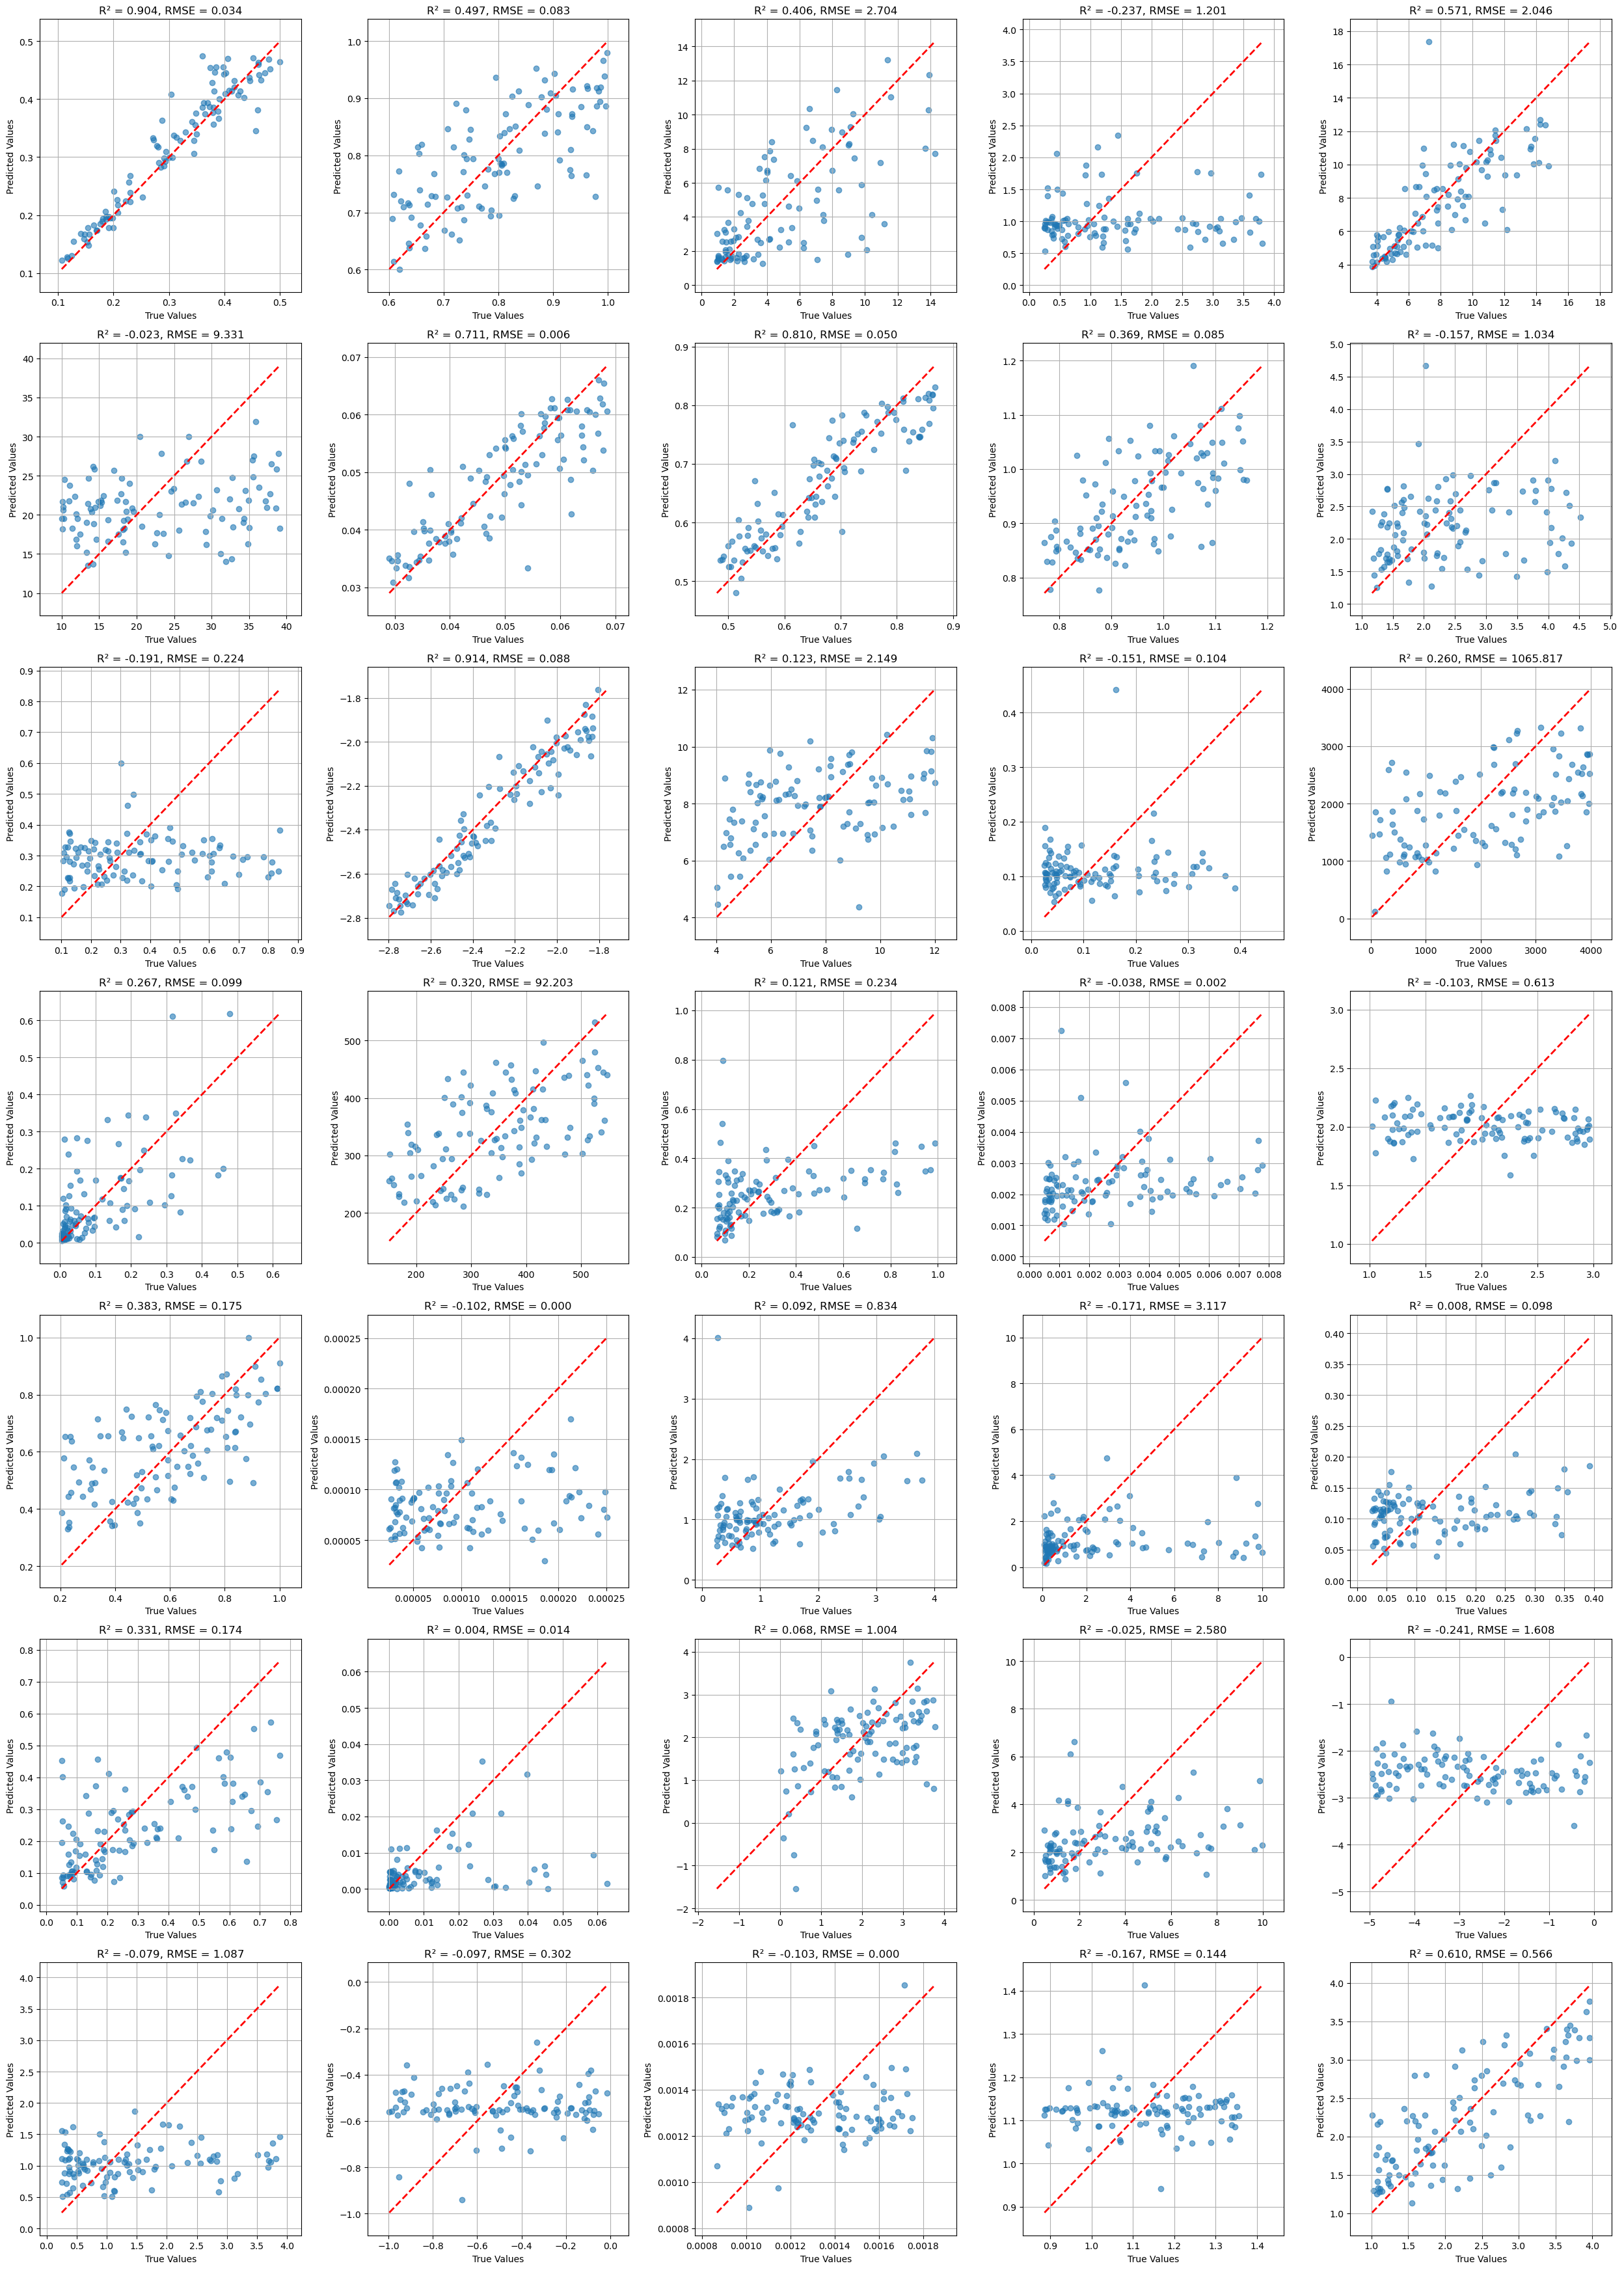

In [53]:
n_cols = int(np.floor(np.sqrt(output_dim)))
n_rows = int(np.ceil(output_dim / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = np.atleast_1d(axes).reshape(n_rows, n_cols)
for i in range(output_dim):
    ax = axes.flat[i]
    predictions = all_predictions[:, i]
    true_values = all_true_values[:, i]
    ax.scatter(true_values, predictions, alpha=0.6)
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    min_val = min(true_values.min(), predictions.min())
    max_val = max(true_values.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'R\u00b2 = {r2:.3f}, RMSE = {rmse:.3f}')
    ax.grid(True)
    span = max_val - min_val
    ax.set_xlim(min_val - 0.1 * span, max_val + 0.1 * span)
    ax.set_ylim(min_val - 0.1 * span, max_val + 0.1 * span)
for j in range(output_dim, n_rows * n_cols):
    fig.delaxes(axes.flat[j])
fig.tight_layout()
fig.savefig('../../../plots/results_plot.png')
plt.show()